# Chunk

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.dataset import OzeDataset
from src.Benchmark import LSTM

In [2]:
# Training parameters
DATASET_PATH = 'dataset_sample.npz'
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 2e-4
EPOCHS = 10

# Model parameters
K = 672 # Time window length
d_model = 64 # Lattent dim
n_layer = 4 # Number of LSTM layers

d_input = 37 # From dataset
d_output = 8 # From dataset

# Config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cpu


## Load dataset

In [3]:
!wget deepnet.fr/challenge_oze/sample_dataset/{DATASET_PATH}

--2019-12-17 20:19:06--  http://deepnet.fr/challenge_oze/sample_dataset/dataset_sample.npz
Resolving deepnet.fr (deepnet.fr)... 2001:8d8:100f:f000::2bc, 217.160.0.45
Connecting to deepnet.fr (deepnet.fr)|2001:8d8:100f:f000::2bc|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://deepnet.fr/challenge_oze/sample_dataset/dataset_sample.npz [following]
--2019-12-17 20:19:06--  https://deepnet.fr/challenge_oze/sample_dataset/dataset_sample.npz
Connecting to deepnet.fr (deepnet.fr)|2001:8d8:100f:f000::2bc|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34982724 (33M)
Saving to: ‘dataset_sample.npz’

dataset_sample.npz  100%[===================>]  33.36M  7.26MB/s    in 4.6s    

2019-12-17 20:19:11 (7.21 MB/s) - ‘dataset_sample.npz’ saved [34982724/34982724]



In [4]:
dataloader = DataLoader(OzeDataset(DATASET_PATH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS
                       )

## Load network

In [5]:
# Load transformer with Adam optimizer and MSE loss function
net = LSTM(d_input, d_model, d_output, n_layer).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()

## Train

[Epoch  10/10]: 100%|██████████| 500/500 [00:08<00:00, 61.11it/s, loss=0.0172]


Loss: 0.017227


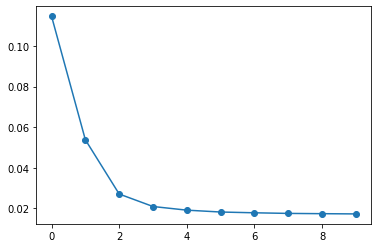

In [6]:
# Prepare loss history
hist_loss = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(netout, y.to(device))

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
    hist_loss[idx_epoch] = running_loss/len(dataloader)
plt.plot(hist_loss, 'o-')
print(f"Loss: {float(hist_loss[-1]):5f}")

## Plot results sample

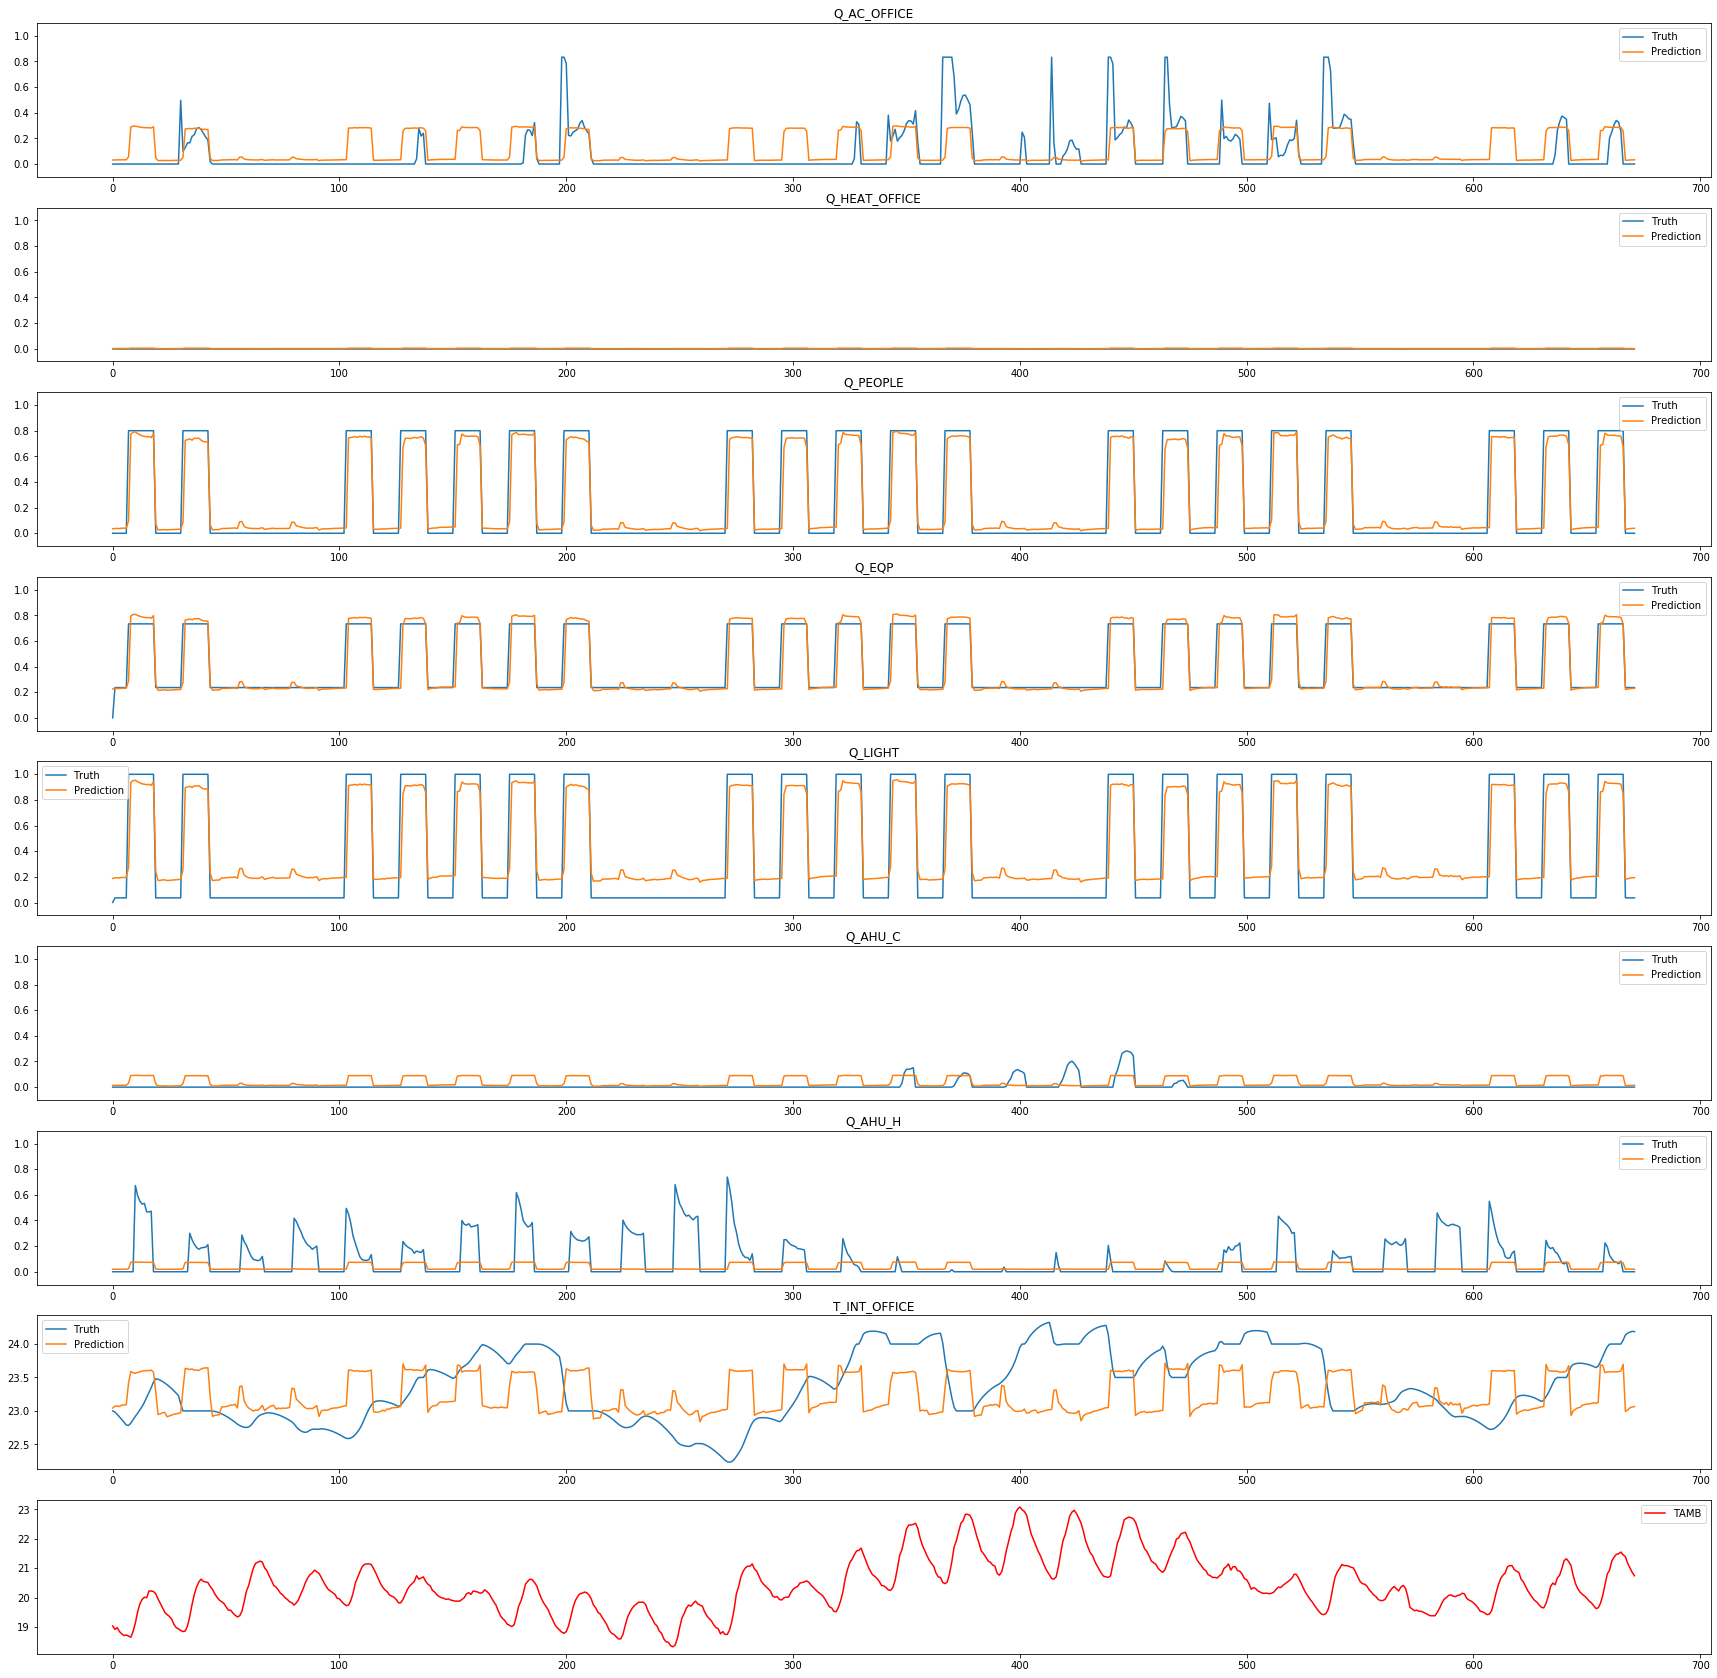

In [7]:
# Select training example
idx = np.random.randint(0, len(dataloader.dataset))
x, y = dataloader.dataset[idx]

# Run predictions
with torch.no_grad():
    netout = net(torch.Tensor(x[np.newaxis, ...]).to(device)).cpu()

plt.figure(figsize=(30, 30))
for idx_label, label in enumerate(dataloader.dataset.labels['X']):
    # Select real temperature
    y_true = y[:, idx_label]
    y_pred = netout[0, :, idx_label].numpy()
    

    plt.subplot(9, 1, idx_label+1)
    

    
    # If consumption, rescale axis
    if label.startswith('Q_'):
        plt.ylim(-0.1, 1.1)
    elif label == 'T_INT_OFFICE':
        y_true = dataloader.dataset.rescale(y_true, idx_label)
        y_pred = dataloader.dataset.rescale(y_pred, idx_label)
        
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(label)
    plt.legend()
    

# Plot ambient temperature
plt.subplot(9, 1, idx_label+2)
t_amb = x[:, dataloader.dataset.labels["Z"].index("TAMB")]
t_amb = dataloader.dataset.rescale(t_amb, -1)
plt.plot(t_amb, label="TAMB", c="red")
plt.legend()

plt.savefig("fig.jpg")